In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from utils.loss import DiceLoss, DiceCrossEntropyLoss
from utils.dataset import BrainMRISliceDataset
from utils.utils import train, validate
from utils.metric import MetricsMonitor, dice_coefficient, dice_score_3d
from utils.vis import plot_images

## Constants

In [2]:
ROOT_DIR = './Data/'
BATCH_SIZE = 16
EPOCHS = 300
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 0
LR = 0.01

## Transforms

In [3]:
train_transform = A.Compose([
    # A.Resize(256, 256),  # Resize both image and mask
    A.HorizontalFlip(p=0.5),  # Flip horizontally
    A.VerticalFlip(p=0.5),  # Flip vertically
    # A.RandomRotate90(p=0.5),  # Randomly rotate 90 degrees
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
    # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),  
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(normalization="min_max", p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize the image
    ToTensorV2()  # Convert to PyTorch tensors
], additional_targets={'mask': 'mask'})  # Specify the target name for the label

test_transform = A.Compose([
    # A.Resize(256, 256),
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(normalization="min_max", p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [17]:
train_transform = A.Compose([
    # Spatial Transformations
    A.OneOf([
        A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.2), rotate=(-30, 30), shear=(-15, 15), p=1.0),  # Scaling, Rotation, Shearing
        A.ElasticTransform(alpha=1.0, sigma=50.0, p=1.0),  # Elastic deformation
    ], p=0.5),  # 50% chance to apply one of the spatial transforms

    # Intensity Perturbations
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),  # Gaussian Blur
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),  # Gaussian Noise
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), elementwise=True, p=1.0),  # Brightness Multiplicative Transform
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),  # Brightness and Contrast
        A.RandomGamma(gamma_limit=(80, 120), p=1.0),  # Gamma Transform
    ], p=0.5),  # 50% chance to apply one of the intensity perturbations

    # Other Transformations
    A.OneOf([
        A.HorizontalFlip(p=1.0),  # Mirroring
        A.VerticalFlip(p=1.0),  # Mirroring
    ], p=0.5),

    # Normalize and convert to tensors
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize to ImageNet stats
    ToTensorV2()
], additional_targets={'mask': 'mask'})  # Include mask augmentation

test_transform = A.Compose([
    # A.Resize(256, 256),
    # A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    # A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    # A.Normalize(normalization="min_max", p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [18]:
train_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'train'), slice_axis=0, transform=train_transform, cache=True, ignore_background=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=0, transform=test_transform, cache=True, ignore_background=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

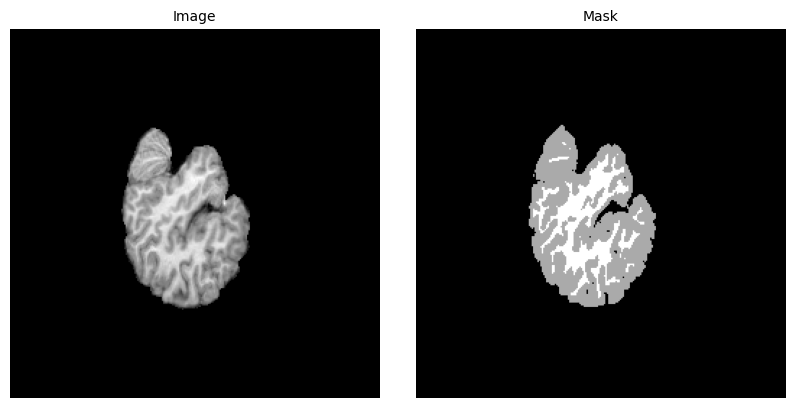

In [11]:
image, mask, volume_idx, slice_idx = val_dataset[82]


plot_images([image.permute(2, 1, 0).numpy(), mask.permute(2, 1, 0).numpy()] , ['Image', 'Mask'], cols=2, figsize=(10, 5))

## Models

In [18]:
model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

## Loss & Optimizer

In [19]:
criterion = DiceCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

## Training

In [20]:
# Monitors
train_monitor = MetricsMonitor(metrics=["loss", "dice_score"])
val_monitor = MetricsMonitor(
    metrics=["loss", "dice_score"], patience=5, mode="max"
)
test_monitor = MetricsMonitor(metrics=["loss", "dice_score"])

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    train(model, train_loader, criterion, optimizer, DEVICE, train_monitor)
    scheduler.step()
    validate(model, val_loader, criterion, DEVICE, val_monitor)

In [ ]:
## Export Model
torch.save(model.state_dict(), "model.pth")

## Predict

### Load model

In [6]:
import mlflow.pytorch
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/huytrnq/BrainSegmentation.mlflow"
logged_model = 'runs:/bd5ae7f392d946dab672e51076446e83/model'

# Load the model
model = mlflow.pytorch.load_model(logged_model, map_location=DEVICE)

In [19]:
predictions = []
labels = []
volume_idxs = []
slice_idxs = []
meta_data = val_dataset.metadata

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks, volume_idx, slice_idx) in enumerate(val_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        predictions.append(outputs)
        labels.append(masks)
        volume_idxs.extend(volume_idx.numpy().tolist())
        slice_idxs.extend(slice_idx.numpy().tolist())
        
predictions = torch.cat(predictions, dim=0).detach().cpu()
labels = torch.cat(labels, dim=0).squeeze(1).long().detach().cpu()
dice_scores = dice_coefficient(predictions, labels, num_classes=4)
print(dice_scores)
print(f"Dice Score: {np.mean(dice_scores)}")

[0.9951168298721313, 0.9340009689331055, 0.9234927892684937, 0.8811143040657043]
Dice Score: 0.9334312230348587


In [20]:
predictions = torch.softmax(predictions.float(), dim=1).cpu().numpy()
predictions = np.argmax(predictions, axis=1)

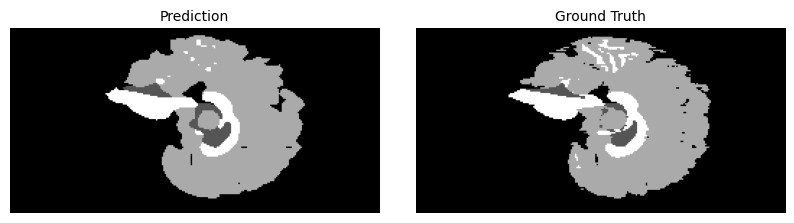

In [21]:
plot_images([predictions[129, :, :], labels[129, :, :].cpu().numpy()], ["Prediction", "Ground Truth"], cols=2)

## Combine 2D segmentation to 3D segmentation

In [22]:
N_TEST = 5
metadata = val_dataset.metadata

In [23]:
# Split the predictions and labels into volumes
predictions = np.array(predictions).reshape(N_TEST, -1, 256, 256)
labels = np.array(labels).reshape(N_TEST, -1, 256, 256)

In [12]:
# Export segmented images
os.makedirs("results", exist_ok=True)

for volume_idx in range(N_TEST):
    print(f"Volume {volume_idx}")
    # Get the metadata for the volume
    image_name = os.path.basename(metadata[volume_idx]["image_path"])
    affine = metadata[volume_idx]["affine"]
    header = metadata[volume_idx]["header"]
    # Get the prediction and label for the volume and remove the padding
    prediction = predictions[volume_idx][:, 64:192, :]
    
    # Export the segmented image
    prediction_nii = nib.Nifti1Image(prediction, affine, header)
    nib.save(prediction_nii, f"results/segmented_{image_name}")

Volume 0


Volume 1
Volume 2
Volume 3
Volume 4


In [26]:
dice_score_3d(predictions, labels, num_classes=4)

{0: 0.99653559923172,
 1: 0.8324748277664185,
 2: 0.8960431814193726,
 3: 0.8690069317817688}